In [1]:
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install gaussian_adaptive_attention
!pip install datasets

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [2]:
import torch

from transformers import GPT2Model, GPT2Config, GPT2Tokenizer

class GPT2WithIntermediateOutputs(GPT2Model):

    def __init__(self, config):

        super().__init__(config)

    def forward(self, input_ids, attention_mask=None):

        # Get embeddings from input

        input_shape = input_ids.size()

        input_ids = input_ids.view(-1, input_shape[-1])

        device = input_ids.device

        if attention_mask is None:

            attention_mask = torch.ones(input_shape, device=device)

        # Prepare attention mask

        if attention_mask.dim() == 3:

            extended_attention_mask = attention_mask[:, None, :, :]

        elif attention_mask.dim() == 2:

            extended_attention_mask = attention_mask[:, None, None, :]

        # Prepare head mask if needed

        head_mask = self.get_head_mask(None, self.config.n_layer)

        # Transformer layers

        hidden_states = self.wte(input_ids) + self.wpe(torch.arange(0, input_shape[-1], device=device))

        hidden_states = self.drop(hidden_states)

        output_shape = input_shape + (hidden_states.size(-1),)

        all_hidden_states = torch.empty((*output_shape, self.config.n_layer + 1), device=device)

        all_hidden_states[..., 0] = hidden_states

        for i, (block, layer_past) in enumerate(zip(self.h, [None]*len(self.h))):

            outputs = block(hidden_states, layer_past=layer_past, attention_mask=extended_attention_mask, head_mask=head_mask[i])

            hidden_states = outputs[0]

            all_hidden_states[..., i+1] = hidden_states

        # Concatenate all hidden states

        concatenated_outputs = all_hidden_states.permute(2, 0, 1, 3).reshape(self.config.n_layer + 1, -1, hidden_states.size(-1))

        return concatenated_outputs


# Example usage:

config = GPT2Config.from_pretrained("gpt2")

model = GPT2WithIntermediateOutputs(config)

print(model)

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

input_ids = torch.tensor([tokenizer.encode("if the vocabulary is known, then the sequence length is correct")])

# Output will have dimensions: [num_layers + 1, batch_size, seq_length, features] (discard element 0 , that's the embedding initial layer)

outputs = model(input_ids)


print(outputs.shape)  # Output dimensions

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

GPT2WithIntermediateOutputs(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

torch.Size([13, 12, 768])


In [2]:
import torch
import torch.nn as nn

class GPT2Classifier(nn.Module):
    def __init__(self, hidden_dim, num_classes):
        super(GPT2Classifier, self).__init__()
        self.fc1 = nn.Linear(hidden_dim, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 128)
        self.dropout = nn.Dropout(0.1)
        self.fc3 = nn.Linear(128, num_classes)
    def forward(self, x):
        x = torch.mean(x, dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

hidden_dim = 768
num_classes = 4

basic_classifier = GPT2Classifier(hidden_dim, num_classes)


In [3]:
from gaussian_adaptive_attention import GaussianAdaptiveAttention
import torch.nn.functional as F
import torch.nn as nn

class ClassifierWithGaussianAttention(nn.Module):
    def __init__(self, hidden_dim, num_classes, num_gaussians, norm_axis):
        super(ClassifierWithGaussianAttention, self).__init__()
        self.attention = GaussianAdaptiveAttention(
            norm_axis=norm_axis,
            num_heads=1,  # Since GaussianAttention is not multi-headed
            num_gaussians=num_gaussians,
            padding_value=0  # You can set this according to your data
        )

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # x shape: [batch_size, seq_length, hidden_dim]

        # Apply Gaussian Adaptive Attention
        context = self.attention(x)

        # Reduce the sequence dimension by averaging
        x = torch.mean(context, dim=1)

        # Pass through fully connected layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.1)
        x = self.fc3(x)
        return x

# Define the parameters for your Gaussian Attention classifier
hidden_dim = 768
num_classes = 4
num_gaussians = 128
norm_axis = -2  # Assuming you want to normalize along the sequence length axis

# Create the classifier with Gaussian Attention
gaussian_classifier = ClassifierWithGaussianAttention(hidden_dim, num_classes, num_gaussians, norm_axis)

In [3]:
import torch.nn as nn
from gaussian_adaptive_attention import MultiHeadGaussianAdaptiveAttention

class ClassifierWithGAAM(nn.Module):
    def __init__(self, num_classes, num_gaussians, norm_axis):
        super().__init__()
        self.gaam = MultiHeadGaussianAdaptiveAttention(
            norm_axis=norm_axis,  # Choose either -2 (sequence length) or 0 (layer number)
            num_heads=5,
            num_gaussians=num_gaussians,
            padding_value=0
        )
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.fc = nn.Linear(64, num_classes)  # This needs to be adjusted based on output size

    def forward(self, x):
        x = self.gaam(x.unsqueeze(0))  # Add channel dimension
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = nn.AdaptiveAvgPool2d((1, 1))(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Initialize classifier
classifier = ClassifierWithGAAM(num_classes=4, num_gaussians=3, norm_axis=-2)


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GaussianAttentionClassifier(nn.Module):
    def __init__(self, hidden_dim, num_classes):
        super(GaussianAttentionClassifier, self).__init__()
        self.hidden_dim = hidden_dim

        # Transformation layer for values
        self.value_transform = nn.Linear(hidden_dim, hidden_dim)

        # Parameters for Gaussian attention
        self.mean = nn.Parameter(torch.rand(1))  # Learnable mean
        self.std_dev = nn.Parameter(torch.rand(1))  # Learnable standard deviation

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 128)
        self.dropout = nn.Dropout(0.1)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x, mask=None):
        batch_size, seq_length, _ = x.shape

        # Dynamically create position indices based on sequence length
        position_indices = torch.arange(seq_length, device=x.device).float().unsqueeze(0)  # [1, seq_length]

        # Transform input for values
        values = self.value_transform(x)  # [batch_size, seq_length, hidden_dim]

        # Calculate Gaussian attention weights
        position_diff = position_indices - self.mean  # [1, seq_length]
        exponent = -0.5 * ((position_diff / self.std_dev) ** 2)
        gaussian_weights = torch.exp(exponent)  # [1, seq_length]
        gaussian_weights = gaussian_weights / gaussian_weights.sum()  # Normalize weights
        gaussian_weights = gaussian_weights.repeat(batch_size, 1).unsqueeze(1)  # [batch_size, 1, seq_length]

        # Apply masking if provided
        if mask is not None:
            mask = mask.float().unsqueeze(1)  # [batch_size, 1, seq_length]
            gaussian_weights *= mask  # Apply mask to Gaussian weights

        # Apply Gaussian attention
        context = torch.bmm(gaussian_weights, values)  # [batch_size, 1, hidden_dim]
        x = context.squeeze(1)  # [batch_size, hidden_dim]

        # Pass through fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Parameters
hidden_dim = 768
num_classes = 4

# Create the classifier with Gaussian attention
gaussian_attention_classifier = GaussianAttentionClassifier(hidden_dim, num_classes)

# Example usage
# Assuming 'input_tensor' is your input batch of shape [batch_size, seq_length, hidden_dim]
# 'mask' is a Boolean tensor of shape [batch_size, seq_length] indicating valid positions (True for valid, False for padded)
# output = gaussian_attention_classifier(input_tensor, mask)


In [4]:
from datasets import Dataset, DatasetDict, load_dataset
import pandas as pd

dataset = load_dataset('ag_news')


def take_a_percentage_of_data(dataset, percentage=0.1, shuffle=True, random_state=None):
    df = pd.DataFrame(dataset)
    df_sorted = df.sort_values(by='label')
    grouped = df_sorted.groupby('label')

    # ensure that proportions of the groups remains the same
    filtered_dfs = []
    for label, group in grouped:
        num_samples_to_keep = int(len(group) * percentage)
        filtered_group = group.head(num_samples_to_keep)
        filtered_dfs.append(filtered_group)

    filtered_df = pd.concat(filtered_dfs)
    if shuffle:
        filtered_df = filtered_df.sample(frac=1, random_state=random_state)

    # filtered_df = pd.concat(filtered_dfs)
    filtered_df.reset_index(drop=True, inplace=True)
    filtered_dict = filtered_df.to_dict(orient='list')
    filtered_dataset = Dataset.from_dict(filtered_dict)
    return filtered_dataset

dataset_train_1percent = take_a_percentage_of_data(dataset['train'], percentage=0.001)
dataset_test_1percent = take_a_percentage_of_data(dataset['test'], percentage=0.01)

combined_dataset_1percent = DatasetDict({
    'train': dataset_train_1percent,
    'test': dataset_test_1percent
})

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [5]:
import pickle

# Process each sentence
processed_data = []
for obj in combined_dataset_1percent['test']:
    label = obj['label']
    text = obj['text']
    input_ids = tokenizer.encode(text, return_tensors='pt')
    with torch.no_grad():
        outputs = model(input_ids)

    processed_data.append((outputs, label))

# Save the processed data
with open('processed_test_data.pkl', 'wb') as f:
    pickle.dump(processed_data, f)

In [6]:
# Process each sentence
processed_data = []
for obj in combined_dataset_1percent['train']:
    label = obj['label']
    text = obj['text']
    input_ids = tokenizer.encode(text, return_tensors='pt')
    with torch.no_grad():
        outputs = model(input_ids)

    processed_data.append((outputs, label))

# Save the processed data
with open('processed_data.pkl', 'wb') as f:
    pickle.dump(processed_data, f)

In [28]:
import torch.optim as optim
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

use_classifier = gaussian_attention_classifier

with open('processed_data.pkl', 'rb') as f:
    processed_data = pickle.load(f)

optimizer = optim.Adam(use_classifier.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Assuming the classifier is ready and 'device' is defined
use_classifier.to(device)
use_classifier.train()

# Prepare data
features, labels = zip(*processed_data)
batch_size = 20
num_batches = len(features) // batch_size

num_epochs = 20

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    for i in range(0, len(features), batch_size):
        optimizer.zero_grad()
        total_loss = 0

        for f, label in zip(features[i:i+batch_size], labels[i:i+batch_size]):
            x = torch.tensor(f).view(1, -1, 768).to(device)
            y = torch.tensor([label], dtype=torch.long).to(device)

            output = use_classifier(x)
            loss = criterion(output, y)
            loss.backward()
            total_loss += loss.item()

        optimizer.step()

        print(f"Batch {i // batch_size + 1}/{num_batches + 1}: Average Loss: {total_loss / batch_size:.2f}")


Epoch 1/20
Batch 1/7: Average Loss: 1.38
Batch 2/7: Average Loss: 1.55
Batch 3/7: Average Loss: 1.56


<ipython-input-28-53d90bab6108>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(f).view(1, -1, 768).to(device)


Batch 4/7: Average Loss: 1.75
Batch 5/7: Average Loss: 2.15
Batch 6/7: Average Loss: 2.34
Epoch 2/20
Batch 1/7: Average Loss: 1.81
Batch 2/7: Average Loss: 1.56
Batch 3/7: Average Loss: 1.44
Batch 4/7: Average Loss: 1.53
Batch 5/7: Average Loss: 1.61
Batch 6/7: Average Loss: 1.59
Epoch 3/20
Batch 1/7: Average Loss: 1.24
Batch 2/7: Average Loss: 1.31
Batch 3/7: Average Loss: 1.07
Batch 4/7: Average Loss: 1.04
Batch 5/7: Average Loss: 1.29
Batch 6/7: Average Loss: 1.05
Epoch 4/20
Batch 1/7: Average Loss: 1.10
Batch 2/7: Average Loss: 0.83
Batch 3/7: Average Loss: 0.99
Batch 4/7: Average Loss: 0.93
Batch 5/7: Average Loss: 1.06
Batch 6/7: Average Loss: 0.66
Epoch 5/20
Batch 1/7: Average Loss: 0.89
Batch 2/7: Average Loss: 0.44
Batch 3/7: Average Loss: 0.57
Batch 4/7: Average Loss: 0.53
Batch 5/7: Average Loss: 1.29
Batch 6/7: Average Loss: 0.78
Epoch 6/20
Batch 1/7: Average Loss: 0.58
Batch 2/7: Average Loss: 0.44
Batch 3/7: Average Loss: 0.46
Batch 4/7: Average Loss: 0.54
Batch 5/7: Aver

In [29]:
import torch.optim as optim
import torch
import pickle

with open('processed_data.pkl', 'rb') as f:
    processed_data = pickle.load(f)

use_classifier.to(device)
use_classifier.eval()

correct_predictions = 0
total_predictions = 0

for x, label in processed_data:
    x = x.to(device)
    label = torch.tensor([label]).to(device)

    with torch.no_grad():
        flattened = x.view(1, -1, 768)
        output = use_classifier(flattened)
        predicted_label = torch.argmax(output, dim=1)
        print(f"Predicted: {predicted_label.item()}, Actual: {label.item()}")

    correct_predictions += (predicted_label == label).sum().item()
    total_predictions += label.size(0)

accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy:.4f}")


Predicted: 3, Actual: 3
Predicted: 3, Actual: 1
Predicted: 3, Actual: 3
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 3, Actual: 3
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 3, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 3, Actual: 3
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 3, Actual: 3
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 3, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 3, Actual: 3
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 3, Actual: 3
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Ac

In [30]:
import torch
import pickle
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load processed test data
with open('processed_test_data.pkl', 'rb') as f:
    processed_data = pickle.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_classifier.to(device)
use_classifier.eval()

# Initialize lists to collect predicted and actual labels
all_predictions = []
all_labels = []

for x, label in processed_data:
    x = x.to(device)
    label = torch.tensor([label]).to(device)

    with torch.no_grad():
        flattened = x.view(1, -1, 768)
        output = use_classifier(flattened)
        predicted_label = torch.argmax(output, dim=1)
        print(f"Predicted: {predicted_label.item()}, Actual: {label.item()}")

    all_predictions.append(predicted_label.item())
    all_labels.append(label.item())

# Calculate accuracy
correct_predictions = np.sum(np.array(all_predictions) == np.array(all_labels))
total_predictions = len(all_labels)
accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy:.4f}")


Predicted: 1, Actual: 3
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 3
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 3, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 3
Predicted: 0, Actual: 3
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 3, Actual: 3
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 3
Predicted: 2, Actual: 2
Predicted: 3, Actual: 3
Predicted: 3, Actual: 3
Predicted: 0, Actual: 0
Predicted: 3, Actual: 3
Predicted: 2, Actual: 2
Predicted: 2, Actual: 3
Predicted: 3, Actual: 2
Predicted: 3, Actual: 0
Predicted: 2, Actual: 3
Predicted: 0, Actual: 3
Predicted: 3, Actual: 3
Predicted: 1, Actual: 2
Predicted: 3, Actual: 1
Predicted: 3, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Ac

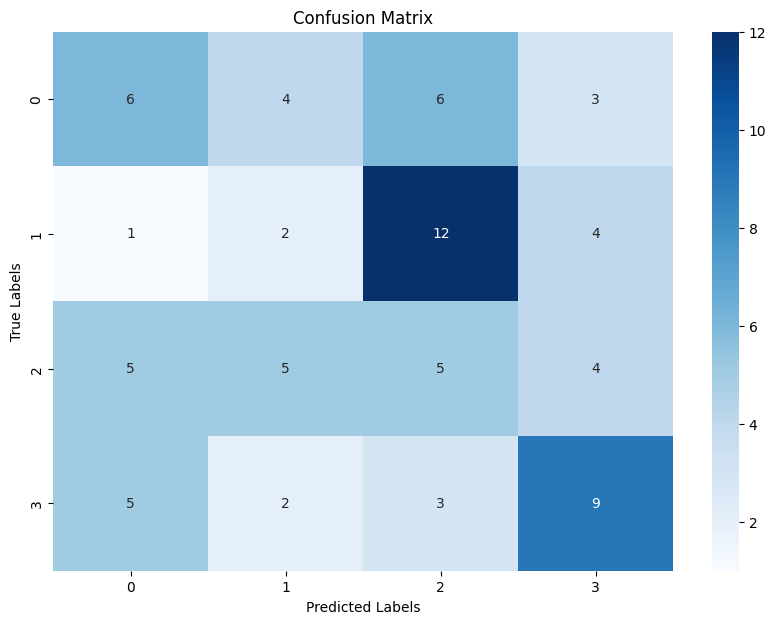

In [31]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()